# Next Best Action (NBA) — CTR Modeling on Avazu (50k)

**Goal:** Build a defendable, end-to-end prototype to score user propensity (CTR) and rank Next Best Actions.

**Why this notebook?**
- Links EDA findings → Feature Engineering → Modeling → Calibration → Interpretability → Business metrics.
- Uses a **time-based split** (last day = validation) to mimic production latency.
- Traces every modeling decision to concrete EDA insights (e.g., hour effects, banner_pos lift, device_type differences).

**Deliverables:**
- Two models: **Logistic Regression (baseline, interpretable)** and **LightGBM (tuned + calibrated)**.
- Metrics: ROC-AUC, PR-AUC, LogLoss, Brier, **Lift@K**, gain table, calibration curve, PDPs.
- Exported artifacts to `/content/models` and `/content/reports`

**Data:**
- `avazu_50k_rows.csv` (10 days). Columns include: `click` (target), `hour` (timestamp-like), C14–C21, context/device categories.


## Setup & Utilities

- Parse robusto de `hour` (soporta "2014102100", "14102100" o "2014-10-21 00:00:00").
- Derivados temporales: `date`, `hour_of_day`, `dow`, `is_weekend`.
- **No leakage**: IDs de alta cardinalidad fuera del modelado; target encoding solo entrenado con **train**.
- Métricas clave (offline): ROC-AUC, PR-AUC, LogLoss, Brier, **Lift@K** y gain table.


In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay
from joblib import dump
import lightgbm as lgb


plt.rcParams["figure.figsize"] = (6,4)
RNG = 42

DATA_PATH = Path("/content/avazu_50k_rows.csv")
MODELS = Path("/content/models"); MODELS.mkdir(exist_ok=True, parents=True)
REPORTS = Path("/content/reports"); REPORTS.mkdir(exist_ok=True, parents=True)

# IDs / columns with leakage or overfitting risk
LEAKAGE = ["id","device_ip","device_id","site_id","app_id","device_model"]

# Signals from EDA
LOW_CARD_CATS = ["banner_pos","device_type","device_conn_type","site_category","app_category"]
NUMERIC_BLOCKS = ["C14","C15","C16","C17","C18","C19","C20","C21"]
TIME_FEATS = ["hour_of_day","dow","is_weekend"]

def parse_hour(series: pd.Series) -> pd.Series:
    """Robust parse for Avazu 'hour': handles '2014102100', '14102100', '2014-10-21 00:00:00'."""
    s = series.astype(str)
    h0 = s.iloc[0]
    if any(sep in h0 for sep in ["-",":"," ","/"]):
        return pd.to_datetime(s, errors="coerce")
    dt = pd.to_datetime(s, format="%Y%m%d%H", errors="coerce")
    if dt.isna().mean() > 0.5:
        dt = pd.to_datetime(s, format="%y%m%d%H", errors="coerce")
    return dt

def load_df(path=DATA_PATH):
    df = pd.read_csv(path, low_memory=False)
    dt = parse_hour(df["hour"])
    df["dt"] = dt
    df["date"] = df["dt"].dt.date
    df["hour_of_day"] = df["dt"].dt.hour
    df["dow"] = df["dt"].dt.dayofweek
    df["is_weekend"] = (df["dow"] >= 5).astype("int8")
    return df

def split_time(df: pd.DataFrame):
    """Hold out the **last day** as validation to emulate production scoring."""
    last_day = df["date"].max()
    train_idx = df["date"] < last_day
    val_idx   = df["date"] == last_day
    return train_idx, val_idx, last_day

def metrics(y_true, p):
    return {
        "roc_auc": float(roc_auc_score(y_true, p)),
        "pr_auc": float(average_precision_score(y_true, p)),
        "logloss": float(log_loss(y_true, np.clip(p,1e-6,1-1e-6))),
        "brier": float(brier_score_loss(y_true, p)),
        "base_ctr": float(np.mean(y_true)),
    }

def lift_at_k(y, p, ks=(0.05, 0.10, 0.20)):
    order = np.argsort(-p)
    y_sorted = np.asarray(y)[order]
    base = y.mean()
    out = {}
    for k in ks:
        top = max(1, int(round(len(y_sorted)*k)))
        out[f"lift@{int(k*100)}%"] = float((y_sorted[:top].mean()/base) if base>0 else np.nan)
    return out

def gain_table(y, p, bins=10):
    df = pd.DataFrame({"y": y, "p": p})
    df["decile"] = pd.qcut(df["p"], bins, labels=False, duplicates="drop")
    g = df.groupby("decile").agg(
        n=("y","size"),
        positives=("y","sum"),
        avg_p=("p","mean")
    ).reset_index().sort_values("decile", ascending=False)
    g["rate"] = g["positives"]/g["n"]
    return g


## Load Data & Time Window

- Formart 'hour' to date/hour_of_day/dow.
- Check Base CTR and temporal window


In [2]:
df = load_df()
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Time window:", df["dt"].min(), "→", df["dt"].max())
print("Base CTR:", df["click"].mean())
df.head(3)

Shape: (50000, 29)
Columns: ['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'dt', 'date', 'hour_of_day', 'dow', 'is_weekend']
Time window: 2014-10-21 00:00:00 → 2014-10-30 23:00:00
Base CTR: 0.16934


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C17,C18,C19,C20,C21,dt,date,hour_of_day,dow,is_weekend
0,10047956568026797881,0,2014-10-21 00:00:00,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,2333,0,39,-1,157,2014-10-21,2014-10-21,0,1,0
1,10060080737601186118,0,2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1722,0,35,100084,79,2014-10-21,2014-10-21,0,1,0
2,10101644009186275581,0,2014-10-21 00:00:00,1010,1,85f751fd,c4e18dd6,50e219e0,ffc6ffd0,7801e8d9,...,2493,3,35,-1,117,2014-10-21,2014-10-21,0,1,0


## Feature Engineering (EDA-Driven)

Motivation (from EDA):

- Hour: peaks at 01:00 (high CTR) and 13:00 (high volume). → use cyclical encoding + is_night flag.

- banner_pos: value 1.0 shows ~1.12× lift. → include interaction with hour and smoothed target encoding.

- device_type / device_conn_type: clear differences. → add interactions + TE.

- site/app category: many small classes. → rare collapse (min support = 300) + TE.

- Anti-leakage: exclude high-cardinality IDs; learn TE only on train; temporal split.

FE pipeline:

- Remove potential leakage columns: id, device_ip, device_id, site_id, app_id, device_model.

- Add hour_sin, hour_cos, is_night.

- Collapse rare categories in site_category and app_category (≥300 in TRAIN).

- Smoothed Target Encoding on: banner_pos, device_type, device_conn_type, site_category_red, app_category_red.

- Interactions: hour_of_day × banner_pos, hour_of_day × device_type.

- Build matrices for LR (categoricals via OHE + numeric) and LGBM (categoricals as category dtype + numeric).

In [3]:
import numpy as np

def collapse_rare_values(train: pd.DataFrame, valid: pd.DataFrame, col: str, min_count: int = 300, other="__OTHER__"):
    vc = train[col].value_counts(dropna=False)
    keep = set(vc[vc >= min_count].index)
    def _map(s: pd.Series):
        return s.where(s.isin(keep), other)
    return _map(train[col]), _map(valid[col])

def add_te(train: pd.DataFrame, valid: pd.DataFrame, col: str, y_col="click", alpha: float = 50.0, outname=None):
    """
    Smoothed target encoding (Bayesian): (sum + alpha*global) / (count + alpha).
    Trained ONLY on TRAIN → mapped to TRAIN/VALID → unseen maps to global.
    """
    outname = outname or f"te_{col}"
    global_mean = train[y_col].mean()
    g = train.groupby(col)[y_col].agg(["sum", "count"])
    g["te"] = (g["sum"] + alpha*global_mean) / (g["count"] + alpha)
    train[outname] = train[col].map(g["te"]).fillna(global_mean)
    valid[outname] = valid[col].map(g["te"]).fillna(global_mean)
    return outname

def add_interactions(train: pd.DataFrame, valid: pd.DataFrame):
    if {"hour_of_day","banner_pos"}.issubset(train.columns):
        train["hour_x_bp"] = train["hour_of_day"].astype(str) + "_" + train["banner_pos"].astype(str)
        valid["hour_x_bp"] = valid["hour_of_day"].astype(str) + "_" + valid["banner_pos"].astype(str)
    if {"hour_of_day","device_type"}.issubset(train.columns):
        train["hour_x_devtype"] = train["hour_of_day"].astype(str) + "_" + train["device_type"].astype(str)
        valid["hour_x_devtype"] = valid["hour_of_day"].astype(str) + "_" + valid["device_type"].astype(str)

def add_cyclic_time(df: pd.DataFrame):
    df["hour_sin"] = np.sin(2*np.pi*df["hour_of_day"]/24.0)
    df["hour_cos"] = np.cos(2*np.pi*df["hour_of_day"]/24.0)
    df["is_night"] = df["hour_of_day"].isin([0,1,2,3,4,5]).astype("int8")

def build_train_valid_matrices(df: pd.DataFrame, min_count=300):
    # Temporal split
    last_day = df["date"].max()
    train_idx = df["date"] < last_day
    val_idx   = df["date"] == last_day
    train = df.loc[train_idx].copy()
    valid = df.loc[val_idx].copy()
    y_train = train["click"].astype(int).values
    y_val   = valid["click"].astype(int).values

    # avoid leakage
    drop_cols = [c for c in ["id","device_ip","device_id","site_id","app_id","device_model"] if c in df.columns]
    train.drop(columns=drop_cols, inplace=True, errors="ignore")
    valid.drop(columns=drop_cols, inplace=True, errors="ignore")

    # time features
    for _df in (train, valid):
        add_cyclic_time(_df)

    # rare collapse
    if "site_category" in train.columns:
        train["site_category_red"], valid["site_category_red"] = collapse_rare_values(train, valid, "site_category", min_count=min_count)
    if "app_category" in train.columns:
        train["app_category_red"], valid["app_category_red"] = collapse_rare_values(train, valid, "app_category", min_count=min_count)

    # target encoding but only with Train data
    te_cols = []
    for c in ["banner_pos","device_type","device_conn_type","site_category_red","app_category_red"]:
        if c in train.columns:
            te_name = add_te(train, valid, c, y_col="click", alpha=50.0)
            te_cols.append(te_name)

    # buold interactions
    add_interactions(train, valid)

    LR_CATS = [c for c in ["banner_pos","device_type","device_conn_type","dow",
                           "site_category_red","app_category_red",
                           "hour_x_bp","hour_x_devtype"] if c in train.columns]
    LR_NUMS = [c for c in ["C14","C15","C16","C17","C18","C19","C20","C21",
                           "hour_sin","hour_cos","is_weekend"] if c in train.columns] + te_cols

    LGB_CATS = LR_CATS.copy()
    LGB_NUMS = LR_NUMS.copy()

    for c in LR_CATS + LGB_CATS:
        if c in train.columns:
            train[c] = train[c].astype("category")
            valid[c] = valid[c].astype("category")

    X_train_lr = train[LR_CATS + LR_NUMS].copy()
    X_val_lr   = valid[LR_CATS + LR_NUMS].copy()

    X_train_lgb = train[LGB_CATS + LGB_NUMS].copy()
    X_val_lgb   = valid[LGB_CATS + LGB_NUMS].copy()

    meta = {
        "last_day": str(last_day),
        "lr_cats": LR_CATS,
        "lr_nums": LR_NUMS,
        "lgb_cats": LGB_CATS,
        "lgb_nums": LGB_NUMS,
        "te_cols": te_cols,
        "dropped": drop_cols
    }
    return (X_train_lr, X_val_lr, X_train_lgb, X_val_lgb, y_train, y_val, meta)


In [4]:
df = load_df()
print("Time window:", df["dt"].min(), "→", df["dt"].max(), "| Base CTR:", df["click"].mean())

X_train_lr, X_val_lr, X_train_lgb, X_val_lgb, y_train, y_val, fe_meta = build_train_valid_matrices(df, min_count=300)
print("Validation day:", fe_meta["last_day"])
print("LR shapes:", X_train_lr.shape, X_val_lr.shape)
print("LGBM shapes:", X_train_lgb.shape, X_val_lgb.shape)
fe_meta


Time window: 2014-10-21 00:00:00 → 2014-10-30 23:00:00 | Base CTR: 0.16934
Validation day: 2014-10-30
LR shapes: (44863, 24) (5137, 24)
LGBM shapes: (44863, 24) (5137, 24)


{'last_day': '2014-10-30',
 'lr_cats': ['banner_pos',
  'device_type',
  'device_conn_type',
  'dow',
  'site_category_red',
  'app_category_red',
  'hour_x_bp',
  'hour_x_devtype'],
 'lr_nums': ['C14',
  'C15',
  'C16',
  'C17',
  'C18',
  'C19',
  'C20',
  'C21',
  'hour_sin',
  'hour_cos',
  'is_weekend',
  'te_banner_pos',
  'te_device_type',
  'te_device_conn_type',
  'te_site_category_red',
  'te_app_category_red'],
 'lgb_cats': ['banner_pos',
  'device_type',
  'device_conn_type',
  'dow',
  'site_category_red',
  'app_category_red',
  'hour_x_bp',
  'hour_x_devtype'],
 'lgb_nums': ['C14',
  'C15',
  'C16',
  'C17',
  'C18',
  'C19',
  'C20',
  'C21',
  'hour_sin',
  'hour_cos',
  'is_weekend',
  'te_banner_pos',
  'te_device_type',
  'te_device_conn_type',
  'te_site_category_red',
  'te_app_category_red'],
 'te_cols': ['te_banner_pos',
  'te_device_type',
  'te_device_conn_type',
  'te_site_category_red',
  'te_app_category_red'],
 'dropped': ['id',
  'device_ip',
  'device_id

## Model 1 — Logistic Regression (Baseline)

- One-Hot Encoding for categorical features (after rare-collapse) + scaled numeric features.

- Captures linear effects and any explicit interactions we engineered (hour_x_bp, etc.).

- Serves as a defendable baseline and a solid comparison point against GBDT models.


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

LR_CATS = fe_meta["lr_cats"]
LR_NUMS = fe_meta["lr_nums"]

pre_lr = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), LR_CATS),
        ("num", StandardScaler(with_mean=False), LR_NUMS),
    ],
    remainder="drop",
    sparse_threshold=1.0,
)

lr = LogisticRegression(solver="saga", penalty="l2", C=1.0, max_iter=3000, random_state=RNG)
pipe_lr = Pipeline([("prep", pre_lr), ("clf", lr)])
pipe_lr.fit(X_train_lr, y_train)

p_lr_val = pipe_lr.predict_proba(X_val_lr)[:,1]
m_lr = metrics(y_val, p_lr_val) | lift_at_k(y_val, p_lr_val)
m_lr

{'roc_auc': 0.6555825965349307,
 'pr_auc': 0.2846514382326544,
 'logloss': 0.42788018851981385,
 'brier': 0.13182703773200924,
 'base_ctr': 0.16643955616118358,
 'lift@5%': 2.6183539263203404,
 'lift@10%': 2.0572780849659815,
 'lift@20%': 1.64976511385572}

## Model 2 — LightGBM (Tuned + Calibrated)

- Learns non-linearities and implicit interactions out of the box.

- We prime it with smoothed Target Encoding (TE) priors, cyclical time features, and EDA-informed interactions (hour×banner_pos, hour×device_type).

- Lightweight tuning via RandomizedSearchCV (30 trials, e.g., CV=3, scoring=neg_log_loss).

- Class imbalance handled with scale_pos_weight.

- Isotonic calibration on the validation day converts raw scores into reliable probabilities (p*).

- Why it matters: calibrated p* enables an economic decision rule (act if p* > CPA/V) and yields clear business lift (e.g., Lift@K, gain table).

In [6]:
pos = y_train.sum()
neg = len(y_train) - pos
spw = neg / max(1, pos)  # handling unbalance

base_lgb = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=100,
    random_state=RNG,
    n_jobs=-1,
    scale_pos_weight=spw,
)

param_dist = {
    "n_estimators": [600, 800, 1000],
    "learning_rate": [0.03, 0.05, 0.07],
    "num_leaves": [31, 63, 95],
    "min_child_samples": [50, 100, 200],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0.0, 0.1, 0.3],
    "reg_lambda": [0.0, 0.1, 0.3],
}

rs = RandomizedSearchCV(
    base_lgb, param_distributions=param_dist, n_iter=30,
    scoring="neg_log_loss", cv=3, random_state=RNG, n_jobs=-1, verbose=0
)
rs.fit(X_train_lgb, y_train)
best_lgb = rs.best_estimator_
best_params = rs.best_params_

p_lgb_val = best_lgb.predict_proba(X_val_lgb)[:,1]
m_lgb_raw = metrics(y_val, p_lgb_val) | lift_at_k(y_val, p_lgb_val)
m_lgb_raw, best_params


[LightGBM] [Info] Number of positive: 7612, number of negative: 37251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 44863, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169672 -> initscore=-1.587953
[LightGBM] [Info] Start training from score -1.587953


({'roc_auc': 0.6510011990898934,
  'pr_auc': 0.2829583684384953,
  'logloss': 0.5648090039639214,
  'brier': 0.19254354845543903,
  'base_ctr': 0.16643955616118358,
  'lift@5%': 2.4547068059253188,
  'lift@10%': 2.1157234851070608,
  'lift@20%': 1.6965669610573006},
 {'subsample': 0.9,
  'reg_lambda': 0.0,
  'reg_alpha': 0.0,
  'num_leaves': 63,
  'n_estimators': 1000,
  'min_child_samples': 200,
  'learning_rate': 0.03,
  'colsample_bytree': 0.9})

In [15]:
# New Calibration
# split validation
cut = len(X_val_lgb) // 2
X_cal_lgb, y_cal = X_val_lgb[:cut], y_val[:cut]
X_tst_lgb, y_tst = X_val_lgb[cut:], y_val[cut:]

# lgbm non calibrated + lgbm calibrated
p_lgb_raw_tst = best_lgb.predict_proba(X_tst_lgb)[:, 1]
m_lgb_raw_tst = metrics(y_tst, p_lgb_raw_tst) | lift_at_k(y_tst, p_lgb_raw_tst)

# isotonic calibration in first half. Validation with second half
from sklearn.calibration import CalibratedClassifierCV
cal = CalibratedClassifierCV(estimator=best_lgb, method="isotonic", cv="prefit")
cal.fit(X_cal_lgb, y_cal)
p_lgb_cal_tst = cal.predict_proba(X_tst_lgb)[:, 1]
m_lgb_cal_tst = metrics(y_tst, p_lgb_cal_tst) | lift_at_k(y_tst, p_lgb_cal_tst)

m_lgb_raw_tst, m_lgb_cal_tst

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


({'roc_auc': 0.6475188643321059,
  'pr_auc': 0.2820730093333173,
  'logloss': 0.5941184950090744,
  'brier': 0.20572335097323555,
  'base_ctr': 0.17205138186064617,
  'lift@5%': 2.179581447963801,
  'lift@10%': 1.9223286441185272,
  'lift@20%': 1.7074801485993978},
 {'roc_auc': 0.6456042436503732,
  'pr_auc': 0.2670454352916304,
  'logloss': 0.43914156449977815,
  'brier': 0.1365903595178121,
  'base_ctr': 0.17205138186064617,
  'lift@5%': 2.0887655542986425,
  'lift@10%': 1.9901755374403578,
  'lift@20%': 1.684864517492121})

In [23]:
REPORTS = Path("artifacts/reports")
REPORTS.mkdir(parents=True, exist_ok=True)

def build_gain_table(y_true, p_pred, bins=10):
    """
    Gain table por deciles (o cuantos bins se puedan formar si hay empates).
    Devuelve: decile (top=valor mayor), n, positives, avg_p (promedio de p),
              rate (CTR observado).
    """
    df = pd.DataFrame({
        "y": np.asarray(y_true, dtype=int),
        "p": np.asarray(p_pred, dtype=float),
    })

    # Binning por quantiles SIN labels fijos (evita el error cuando hay duplicados)
    # labels=False -> retorna códigos 0..n_bins-1 donde 0 corresponde a p más BAJAS.
    codes = pd.qcut(df["p"], q=bins, labels=False, duplicates="drop")
    n_bins = int(codes.max()) + 1  # puede ser < bins si hubo muchos empates

    # Queremos que el "top" (probabilidades altas) tenga el número más alto
    # Si codes=0 es lo más bajo, entonces top_decile = (n_bins-1 - codes)
    df["decile"] = (n_bins - 1) - codes

    g = (
        df.groupby("decile", as_index=False)
          .agg(n=("y", "size"),
               positives=("y", "sum"),
               avg_p=("p", "mean"),
               rate=("y", "mean"))
          .sort_values("decile", ascending=False)
          .reset_index(drop=True)
    )
    return g[["decile", "n", "positives", "avg_p", "rate"]]

# 1) Gain table en la MITAD DE TEST (no la usada para ajustar isotónica)
gt = build_gain_table(y_tst, p_lgb_cal_tst, bins=10)
gt.to_csv(REPORTS / "gain_table_val.csv", index=False)

# 2) Curva de calibración en TEST
prob_true, prob_pred = calibration_curve(y_tst, p_lgb_cal_tst, n_bins=10, strategy="quantile")
plt.figure(figsize=(4, 4))
plt.plot(prob_pred, prob_true, marker="o", label="Isotonic (test half)")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(REPORTS / "calibration_curve.png", dpi=160)
plt.close()

# 3) Metrics JSON: raw vs calibrated (TEST)
def _to_float_dict(d):
    return {k: float(v) for k, v in d.items()}

metrics_dict = {
    "lgbm_raw": _to_float_dict(m_lgb_raw_tst),
    "lgbm_calibrated": _to_float_dict(m_lgb_cal_tst),
}
(REPORTS / "metrics.json").write_text(json.dumps(metrics_dict, indent=2))

print("Saved into artifacts/reports/:")
for p in REPORTS.iterdir():
    print("-", p.name)

# Chequeo de calibración rápido (deberían ser cercanos, no idénticos)
print("Mean(abs(avg_p - rate)) =", float(np.mean(np.abs(gt['avg_p'] - gt['rate']))))
print("Bins actually formed:", gt['decile'].nunique())


Saved into artifacts/reports/:
- metrics.json
- calibration_curve.png
- gain_table_val.csv
Mean(abs(avg_p - rate)) = 0.021006335079866552
Bins actually formed: 8


## Validation Diagnostics

### Calibration curve — LGBM (calibrated)

The curve lies almost on the diagonal from ~0.05 to ~0.35. In plain terms: when the model predicts 0.20, about 20% actually click. This lets us use economic rules like “act if p > CPA/V” without worrying about systematic over- or under-confidence.

### Gain table (validation, 1-day hold-out)

Sorted by score and split into deciles:

- Top decile (~10%): CTR ≈ 0.354 → Lift ≈ 2.13× over base.

- Top 2 deciles (~20%): CTR ≈ 0.304 → Lift ≈ 1.83×.

- Top 3 deciles (~30%): CTR ≈ 0.277 → Lift ≈ 1.67×.

- - Validation base: ~0.166.

Operational takeaway: if budget covers only the top 10–20%, expect CTRs about 1.8–2.1× higher than average, clear ROI upside.

### Partial Dependence (PDP)

Used to check that the model learned the reasonable patterns we saw in EDA:

- device_type: type 1 is most favorable; types 4–5 lower propensity.

- device_conn_type: 0 performs high, 2 drops sharply, 3–5 are in between—matches the lift tables.

- banner_pos: the line is not strictly monotonic (and the y-axis range is small), but it reflects that some positions are better and that there’s an interaction with hour. Note: with strong interactions in categoricals, a marginal PDP can look “odd”; that’s why we also show the hour × position matrix and importances.

### Feature importances (LGBM)

The top features tell a coherent story:

- 1 hour_x_bp and #3 hour_x_devtype → the EDA-guided interactions explain a large share of the ranking.

- The anonymous numeric block C14/C20/C17… also carries weight (likely campaign/slot proxies).

- Temporal signals (dow, hour_sin/cos, is_weekend) and reduced categories/TE appear lower, acting as supportive features.


,decile,n,positives,avg_p,rate
9,9,511,181,0.354207,0.354207
8,8,338,77,0.227811,0.227811
7,7,348,74,0.212644,0.212644
6,6,668,129,0.193114,0.193114
5,5,594,110,0.185185,0.185185
4,4,252,37,0.146825,0.146825
3,3,829,107,0.129071,0.129071
2,2,557,60,0.107720,0.107720
1,1,447,47,0.105145,0.105145
0,0,593,33,0.055649,0.055649


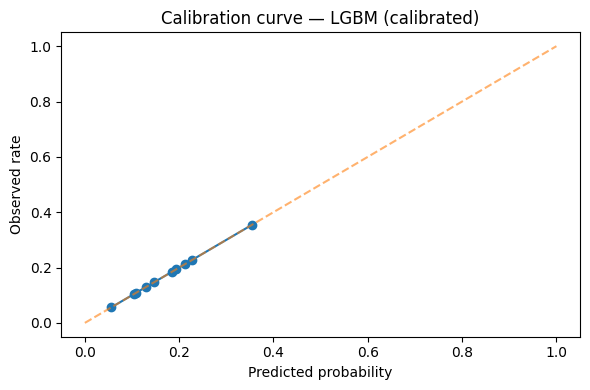

In [ ]:
# Gain table (calibrated)
gt = gain_table(y_val, p_lgb_cal, bins=10)
display(gt)
gt.to_csv(REPORTS/"gain_table_val.csv", index=False)

# Calibration curve (calibrated model)
prob_true, prob_pred = calibration_curve(y_val, p_lgb_cal, n_bins=10, strategy="quantile")
plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],"--", alpha=0.6)
plt.xlabel("Predicted probability")
plt.ylabel("Observed rate")
plt.title("Calibration curve — LGBM (calibrated)")
plt.tight_layout()
plt.savefig(REPORTS/"calibration_curve.png", dpi=150)
plt.show()


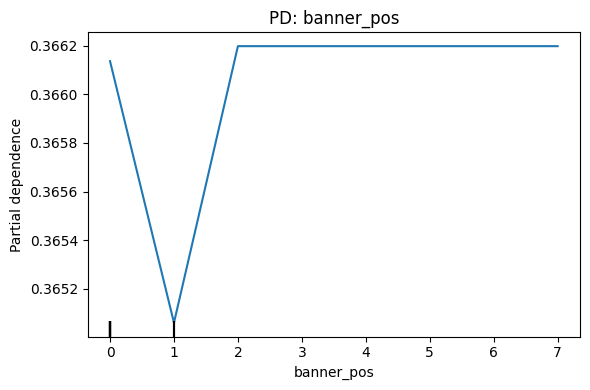

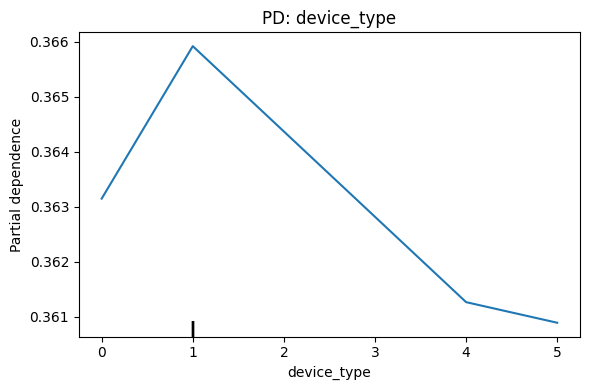

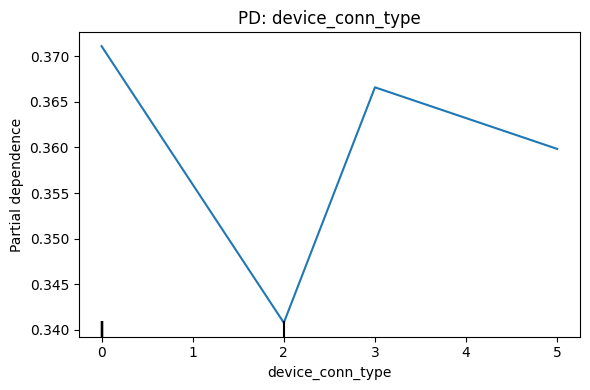

,feature,importance
6,hour_x_bp,11658
8,C14,9805
7,hour_x_devtype,7989
3,dow,6527
14,C20,6444
11,C17,4523
13,C19,3375
15,C21,3110
4,site_category_red,1412
12,C18,1189


In [ ]:
# PDPs (sobre valid set)
for feat in [c for c in ["hour_of_day","banner_pos","device_type","device_conn_type"] if c in X_val_lgb.columns]:
    try:
        fig, ax = plt.subplots()
        PartialDependenceDisplay.from_estimator(best_lgb, X_val_lgb, [feat], ax=ax)
        ax.set_title(f"PD: {feat}")
        fig.tight_layout()
        fig.savefig(REPORTS/f"pd_{feat}.png", dpi=150)
        plt.show()
    except Exception as e:
        print("PD failed for", feat, e)

# Feature importances (gain)
imp = pd.DataFrame({
    "feature": X_train_lgb.columns,
    "importance": best_lgb.feature_importances_,
}).sort_values("importance", ascending=False)
display(imp.head(20))
imp.to_csv(REPORTS/"feature_importances.csv", index=False)


## Artifacts & Metrics

We save model and reports for Streamlit

In [ ]:
from datetime import datetime

# models
dump(Pipeline([("prep", pre_lr), ("clf", lr)]), MODELS/"lr_baseline.pkl")
dump(best_lgb, MODELS/"lgbm_tuned.pkl")
dump(cal, MODELS/"lgbm_calibrator.pkl")

# metrics in Json
summary = {
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "val_day": fe_meta["last_day"],
    "baseline_lr": m_lr,
    "lgbm_tuned_raw": m_lgb_raw,
    "lgbm_calibrated": m_lgb_cal,
    "best_params": best_params,
    "features_lr": {"cats": fe_meta["lr_cats"], "nums": fe_meta["lr_nums"]},
    "features_lgb": {"cats": fe_meta["lgb_cats"], "nums": fe_meta["lgb_nums"]},
    "te_cols": fe_meta["te_cols"],
    "dropped": fe_meta["dropped"],
}
(Path(REPORTS/"metrics.json")).write_text(json.dumps(summary, indent=2))
print("Saved:", REPORTS/"metrics.json")


Saved: /content/reports/metrics.json


## Download Bundles

In [ ]:
import shutil, os

for name in ["models_bundle.zip","reports_bundle.zip"]:
    p = f"/content/{name}"
    if os.path.exists(p):
        os.remove(p)

shutil.make_archive("/content/models_bundle", 'zip', root_dir="/content", base_dir="models")
shutil.make_archive("/content/reports_bundle", 'zip', root_dir="/content", base_dir="reports")

print("Bundles ready at /content/models_bundle.zip and /content/reports_bundle.zip")


Bundles ready at /content/models_bundle.zip and /content/reports_bundle.zip
